In [1]:
# ! pip install transformers

In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # CUDA is available, print information about the GPU
    print(f"CUDA is available. Found {torch.cuda.device_count()} GPU(s).")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")


CUDA is available. Found 1 GPU(s).
GPU 0: NVIDIA GeForce GTX 1050


# Setup environment

In [6]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

In [7]:
# Set Working Directory - if working on Local Machine
import os
os.chdir('D:\FYP\Coding_Work\Jupyter_Notebooks\SpamDetection\Data')

In [11]:
import pandas as pd

file_path = 'SMSSpamCollection'
data = []

with open(file_path, 'r') as f:
    for line in f.readlines():
        split = line.strip().split('\t')
        if len(split) == 2:  # Make sure each line contains both label and text
            label = 1 if split[0] == 'spam' else 0
            text = split[1]
            data.append({'label': label, 'text': text})

df = pd.DataFrame(data)


In [12]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
text = df.text.values
labels = df.label.values # as numpy arrays

In [14]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [15]:
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]),
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ ok       │        7929 │
├──────────┼─────────────┤
│ then     │        2059 │
├──────────┼─────────────┤
│ i        │        1045 │
├──────────┼─────────────┤
│ will     │        2097 │
├──────────┼─────────────┤
│ come     │        2272 │
├──────────┼─────────────┤
│ to       │        2000 │
├──────────┼─────────────┤
│ ur       │       24471 │
├──────────┼─────────────┤
│ home     │        2188 │
├──────────┼─────────────┤
│ after    │        2044 │
├──────────┼─────────────┤
│ half     │        2431 │
├──────────┼─────────────┤
│ an       │        2019 │
├──────────┼─────────────┤
│ hour     │        3178 │
╘══════════╧═════════════╛


In [16]:
df.label.value_counts()

label
0    4827
1     747
Name: count, dtype: int64

In [17]:
word_counts = df.text.apply(lambda x: len(x.split()))

In [18]:
mean_length = np.mean(word_counts)
median_length = np.median(word_counts)
percentile_95 = np.percentile(word_counts, 95)

print(f"Mean token count: {mean_length}")
print(f"Median token count: {median_length}")
print(f"95th percentile token count: {percentile_95}")

Mean token count: 15.59167563688554
Median token count: 12.0
95th percentile token count: 33.0


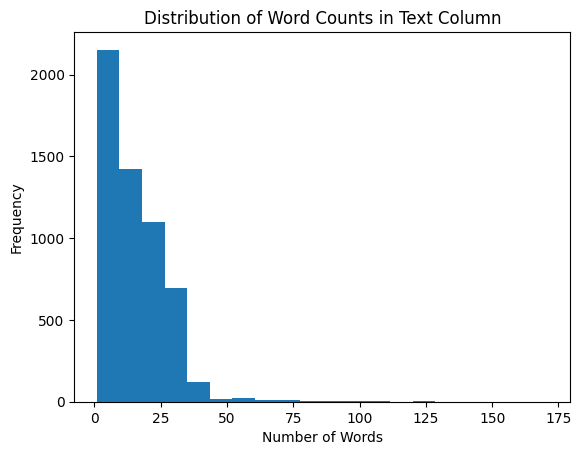

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

plt.hist(word_counts, bins=20)  # You can adjust the number of bins as needed
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Text Column')
plt.show()


In [21]:
# NOTE: max_length = 32

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


token_id = []
attention_masks = []

for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids'])
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Owner\anaconda3\envs\cudatest\lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
token_id[6]

tensor([ 101, 2130, 2026, 2567, 2003, 2025, 2066, 2000, 3713, 2007, 2033, 1012,
        2027, 7438, 2033, 2066, 8387, 7353, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

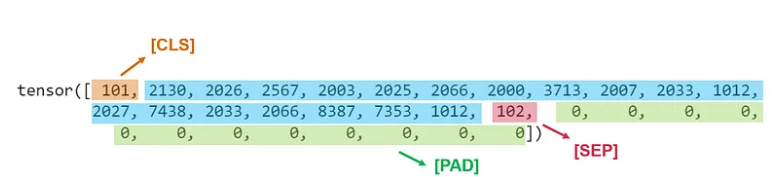

In [23]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ they     │        2027 │                1 │
├──────────┼─────────────┼──────────────────┤
│ can      │        2064 │                1 │
├──────────┼─────────────┼──────────────────┤
│ try      │        3046 │                1 │
├──────────┼─────────────┼──────────────────┤
│ !        │         999 │                1 │
├──────────┼─────────────┼──────────────────┤
│ they     │        2027 │                1 │
├──────────┼─────────────┼──────────────────┤
│ can      │        2064 │                1 │
├──────────┼─────────────┼──────────────────┤
│ get      │        2131 │                1 │
├──────────┼─────────────┼──────────────────┤
│ lost     │        2439 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ,        │        1010 │        

In [24]:

val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx],
                          attention_masks[train_idx],
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx],
                        attention_masks[val_idx],
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

# Training

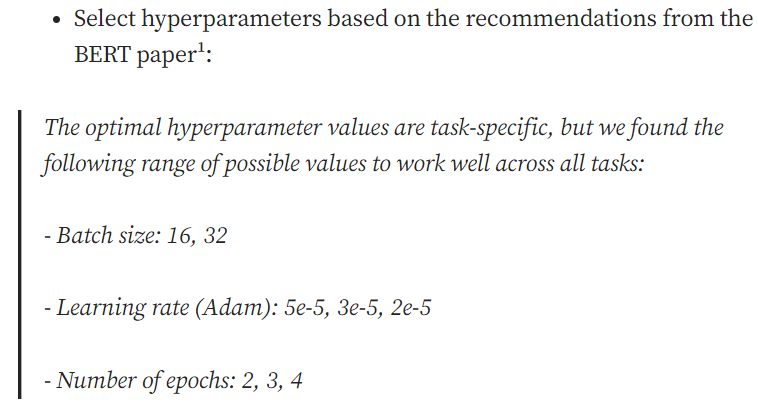

In [25]:

def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [26]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Run on GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [27]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  50%|█████     | 1/2 [01:32<01:32, 92.10s/it]


	 - Train loss: 0.0935
	 - Validation Accuracy: 0.9911
	 - Validation Precision: 1.0000
	 - Validation Recall: 0.9373
	 - Validation Specificity: 1.0000



Epoch: 100%|██████████| 2/2 [03:00<00:00, 90.15s/it]


	 - Train loss: 0.0362
	 - Validation Accuracy: 0.9929
	 - Validation Precision: 0.9851
	 - Validation Recall: 0.9498
	 - Validation Specificity: 0.9991



In [29]:
# Save the trained model
torch.save(model.state_dict(), 'spam_detection_BERT_finetuned_model.pth')

In [30]:
# # load weights of best model
# path = 'spam_detection_BERT_finetuned_model.pt'
# model.load_state_dict(torch.load(path))

FileNotFoundError: [Errno 2] No such file or directory: 'spam_detection_BERT_finetuned_model.pt'

In [26]:
new_sentence = 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Spam' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Ham'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Predicted Class:  Spam


c:\Users\Owner\anaconda3\envs\test1\lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
